In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
%matplotlib inline
sns.set(color_codes=True)

In [76]:
source=pd.read_excel('Данные для тестового задания 2.xlsx', skiprows=1)

In [77]:
df=source.drop(source.columns[5:10], axis=1)

In [4]:
print(source.isnull().values.any())
source.info()

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8411 entries, 0 to 8410
Data columns (total 10 columns):
Нагрузка             8411 non-null float64
Датчик расхода       8411 non-null float64
Датчик уровня 1      8411 non-null float64
Датчик уровня 2      8411 non-null float64
Датчик давления      8411 non-null float64
Нагрузка.1           8411 non-null float64
Датчик расхода.1     8411 non-null float64
Датчик уровня 1.1    8411 non-null float64
Датчик уровня 2.1    8411 non-null float64
Датчик давления.1    8411 non-null float64
dtypes: float64(10)
memory usage: 657.2 KB


Датчик давления и расхода характеризуются крайне низкой дисперсией, то есть его вариативность низкая, первые претенденты на не использование в модели

In [5]:
df.describe()

,Нагрузка,Датчик расхода,Датчик уровня 1,Датчик уровня 2,Датчик давления
count,8411.000000,8411.000000,8411.000000,8411.000000,8411.000000
mean,8.492955,10.147531,1067.535184,1141.963531,0.491700
std,0.153881,0.294863,50.638544,56.541302,0.048218
min,7.983333,0.000000,978.573333,940.150000,0.218033
25%,8.396667,9.936667,1046.848333,1128.300000,0.469683
50%,8.480000,10.184000,1054.266667,1146.293333,0.497600
75%,8.580000,10.329000,1078.835000,1160.418333,0.518350
max,11.366667,12.014000,2508.460000,2465.916667,0.667067


Явных признаков с высокой корреляцией нет

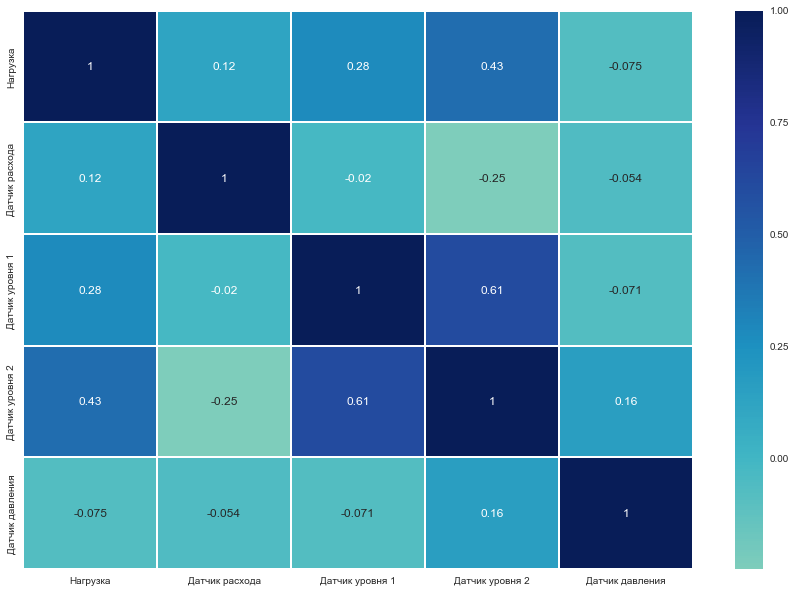

In [6]:
sns.set(rc={'figure.figsize':(15.0,10)})
sns.heatmap(df.corr(),
            annot=True,
            linewidths=1.0,
            center=0,
            cbar=True,
            cmap="YlGnBu")

Распределения всех признаков

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


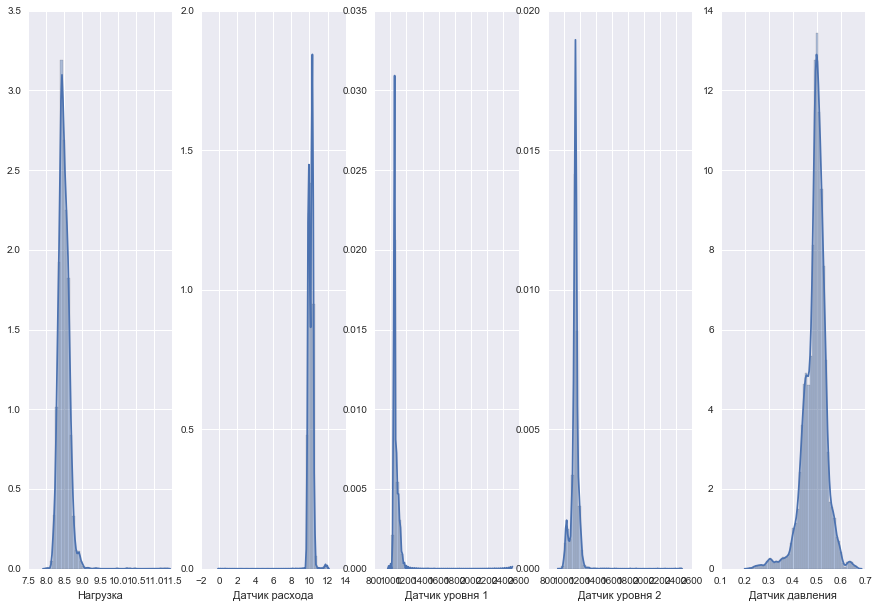

In [7]:
fig, ax =plt.subplots(1,5)
sns.distplot(df[df.columns[0]], ax=ax[0])
sns.distplot(df[df.columns[1]], ax=ax[1])
sns.distplot(df[df.columns[2]], ax=ax[2])
sns.distplot(df[df.columns[3]], ax=ax[3])
sns.distplot(df[df.columns[4]], ax=ax[4])
fig.show()

Из графиков плотности и ящиков с усами видно что в данных есть множество аномальных экземпляров

Попытаемся обучить на таких данных, а после попробуем удалить аномалии

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


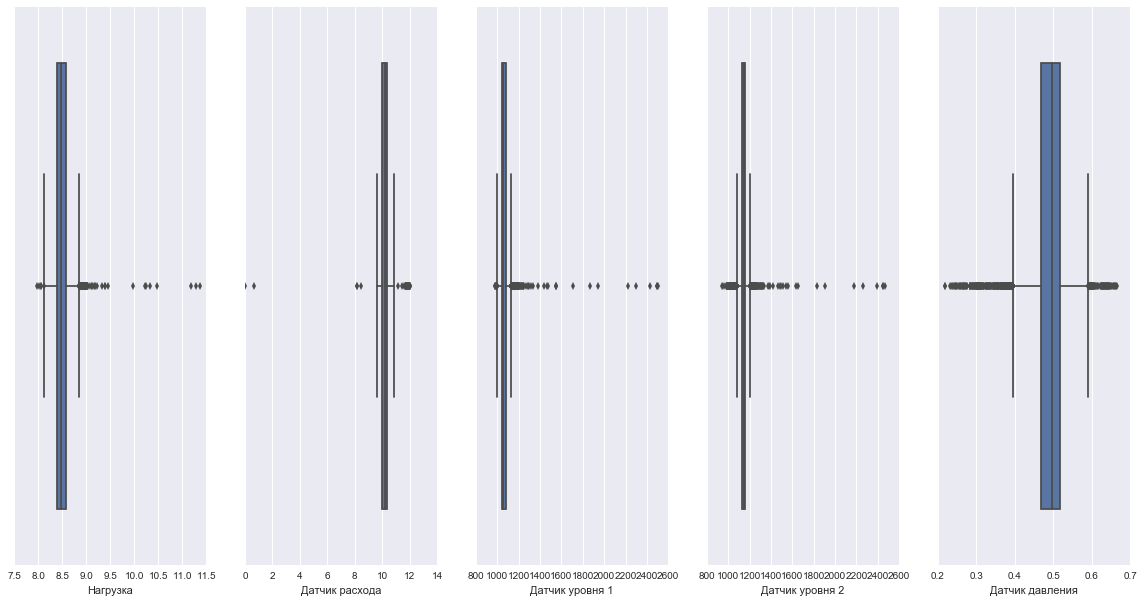

In [8]:
sns.set(rc={'figure.figsize':(20.0,10)})
fig, ax =plt.subplots(1,5)
sns.boxplot(df[df.columns[0]], ax=ax[0])
sns.boxplot(df[df.columns[1]], ax=ax[1])
sns.boxplot(df[df.columns[2]], ax=ax[2])
sns.boxplot(df[df.columns[3]], ax=ax[3])
sns.boxplot(df[df.columns[4]], ax=ax[4])
fig.show()

In [34]:
def RF_results(X_train, y_train,X_valid,y_valid, X_test, y_test):
    model = RandomForestRegressor(n_estimators=500, max_depth=10)
    model.fit(X_train, y_train)
    #проверка на валидационном сете
    val_pred = model.predict(X_valid)
    r2_val= r2_score(y_valid, val_pred)
    #проверка на тестовом сете
    test_pred = model.predict(X_test)
    r2_test= r2_score(y_test, test_pred)
    return r2_val, r2_test
    #return (print("RF score on validation set: {:.2f}".format(r2_val),"Test set score : {:.2f}".format(r2_test) ))

In [35]:
def GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test):
    model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=10)
    model.fit(X_train, y_train)
    #проверка на валидационном сете
    val_pred = model.predict(X_valid)
    r2_val= r2_score(y_valid, val_pred)
    #проверка на тестовом сете
    test_pred = model.predict(X_test)
    r2_test= r2_score(y_test, test_pred)
    return r2_val, r2_test
    #return (print("GBM score on validation set: {:.2f}".format(r2_val),"Test set score : {:.2f}".format(r2_test) ))

Отделим тестовый набор данных, затем будем делить выборку на обучающаю и валидационную
деля её случайным образом 10 раз, усредняя значения на валидционном и тестовом наборе.
В качестве регрессов возьмём градиентный бустинг и случайный лес.
Получены не очень хорошие результаты на уровне 0.5 r^2

In [38]:
#df1=df.drop('Датчик расхода', axis=1)
#source1=source.drop('pod3', axis=1)

valGBM=[]
testGBM=[]
valRF=[]
testRF=[]

#перемешаем данные
df.sample(frac=1)
# отделим отдельно выборку для теста
X_trainval, X_test, y_trainval, y_test = train_test_split(
   df.drop('Нагрузка',axis=1), df.Нагрузка)


for number in range(10):
#перемешаем данные снова, что бы перестраховаться от случая, что в результате рандома получатся "идеальные выборки"
    X_trainval.sample(frac=1)
    #создадим тренировчную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval)
    valG,testG=GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valGBM.append(valG)
    testGBM.append(testG)
    valR,testR=RF_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valRF.append(valR)
    testRF.append(testR)
    #print ("GBM score on validation set: {:.2f}".format(valG),"Test set score : {:.2f}".format(testG) )
    #print ("RF score on validation set: {:.2f}".format(valR),"Test set score : {:.2f}".format(testR) )
    #print ("SVM score on validation set: {:.2f}".format(valS),"Test set score : {:.2f}".format(testS) )
R2_GBM_val=sum(valGBM)/len(valGBM)
R2_GBM_test=sum(testGBM)/len(testGBM)

R2_RF_val=sum(valRF)/len(valRF)
R2_RF_test=sum(testRF)/len(testRF)



print ("mean GBM score on validation set: {:.2f}".format(R2_GBM_val))
print ("mean GBM score on test set: {:.2f}".format(R2_GBM_test))
print ("mean RF score on validation set: {:.2f}".format(R2_RF_val))
print ("mean RF score on test set: {:.2f}".format(R2_RF_test))


mean GBM score on validation set: 0.51
mean GBM score on test set: 0.50
mean RF score on validation set: 0.55
mean RF score on test set: 0.55


Далее попробуем убрать параметры с околонулевой дисперсией
Метрика качества немного ухудшилась

In [40]:
df1=df.drop('Датчик расхода', axis=1)
df1=df.drop('Датчик давления', axis=1)


valGBM=[]
testGBM=[]
valRF=[]
testRF=[]

#перемешаем данные
df1.sample(frac=1)
# отделим отдельно выборку для теста
X_trainval, X_test, y_trainval, y_test = train_test_split(
   df1.drop('Нагрузка',axis=1), df1.Нагрузка)


for number in range(10):
#перемешаем данные снова, что бы перестраховаться от случая, что в результате рандома получатся "идеальные выборки"
    X_trainval.sample(frac=1)
    #создадим тренировчную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval)
    valG,testG=GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valGBM.append(valG)
    testGBM.append(testG)
    valR,testR=RF_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valRF.append(valR)
    testRF.append(testR)
    #print ("GBM score on validation set: {:.2f}".format(valG),"Test set score : {:.2f}".format(testG) )
    #print ("RF score on validation set: {:.2f}".format(valR),"Test set score : {:.2f}".format(testR) )
    #print ("SVM score on validation set: {:.2f}".format(valS),"Test set score : {:.2f}".format(testS) )
R2_GBM_val=sum(valGBM)/len(valGBM)
R2_GBM_test=sum(testGBM)/len(testGBM)

R2_RF_val=sum(valRF)/len(valRF)
R2_RF_test=sum(testRF)/len(testRF)



print ("mean GBM score on validation set: {:.2f}".format(R2_GBM_val))
print ("mean GBM score on test set: {:.2f}".format(R2_GBM_test))
print ("mean RF score on validation set: {:.2f}".format(R2_RF_val))
print ("mean RF score on test set: {:.2f}".format(R2_RF_test))


mean GBM score on validation set: 0.34
mean GBM score on test set: 0.48
mean RF score on validation set: 0.44
mean RF score on test set: 0.57


Следуюим этапом попробуем убрать аномалии изолирующим лесом, и повторить прошлый шаг.

In [41]:
data = df
x = data.drop(data.columns[0], axis=1)
y = data.iloc[:, 0]
model = IsolationForest(n_jobs=4)
model.fit(x, y)
anom = model.predict(x)
df = data[anom == 1]


Результаты стали хуже.

In [42]:
#df1=df.drop('Датчик расхода', axis=1)
#df1=df.drop('Датчик давления', axis=1)


valGBM=[]
testGBM=[]
valRF=[]
testRF=[]

#перемешаем данные
df.sample(frac=1)
# отделим отдельно выборку для теста
X_trainval, X_test, y_trainval, y_test = train_test_split(
   df.drop('Нагрузка',axis=1), df.Нагрузка)


for number in range(10):
#перемешаем данные снова, что бы перестраховаться от случая, что в результате рандома получатся "идеальные выборки"
    X_trainval.sample(frac=1)
    #создадим тренировчную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval)
    valG,testG=GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valGBM.append(valG)
    testGBM.append(testG)
    valR,testR=RF_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valRF.append(valR)
    testRF.append(testR)
    #print ("GBM score on validation set: {:.2f}".format(valG),"Test set score : {:.2f}".format(testG) )
    #print ("RF score on validation set: {:.2f}".format(valR),"Test set score : {:.2f}".format(testR) )
    #print ("SVM score on validation set: {:.2f}".format(valS),"Test set score : {:.2f}".format(testS) )
R2_GBM_val=sum(valGBM)/len(valGBM)
R2_GBM_test=sum(testGBM)/len(testGBM)

R2_RF_val=sum(valRF)/len(valRF)
R2_RF_test=sum(testRF)/len(testRF)



print ("mean GBM score on validation set: {:.2f}".format(R2_GBM_val))
print ("mean GBM score on test set: {:.2f}".format(R2_GBM_test))
print ("mean RF score on validation set: {:.2f}".format(R2_RF_val))
print ("mean RF score on test set: {:.2f}".format(R2_RF_test))

mean GBM score on validation set: 0.33
mean GBM score on test set: 0.31
mean RF score on validation set: 0.40
mean RF score on test set: 0.38


Посчитаем отдельно ошибку предсказанных и реальных данных

In [78]:
def GBM_results1(X_train, y_train,X_valid,y_valid, X_test, y_test):
    model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=10)
    model.fit(X_train, y_train)
    #проверка на валидационном сете
    val_pred = model.predict(X_valid)
    r2_val= mean_squared_error(y_valid, val_pred)
    #проверка на тестовом сете
    test_pred = model.predict(X_test)
    r2_test= mean_squared_error(y_test, test_pred)
    return r2_val, r2_test
    #return (print("GBM score on validation set: {:.2f}".format(r2_val),"Test set score : {:.2f}".format(r2_test) ))

In [82]:
valGBM=[]
testGBM=[]

df.sample(frac=1)
X_trainval, X_test, y_trainval, y_test = train_test_split(
   df.drop('Нагрузка',axis=1), df[df.columns[0]])


for number in range(10):
    X_trainval.sample(frac=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval)
    valG,testG=GBM_results1(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valGBM.append(valG)
    testGBM.append(testG)

R2_GBM_val=sum(valGBM)/len(valGBM)
R2_GBM_test=sum(testGBM)/len(testGBM)



print ("mean GBM RMSE score on validation set: {:.2f}".format(R2_GBM_val))
print ("mean GBM RMSE score on test set: {:.2f}".format(R2_GBM_test))

mean GBM RMSE score on validation set: 0.01
mean GBM RMSE score on test set: 0.01


Краткий вывод, выбранный способ фильтрации не позволил улучшить модель
Признаки слабо коррелированы, для хорошего предсказания нужны дополнительные данные, либо их нужно создавать вручную (разные ухищрения с признаками, либо проекции PCA и TSNE, либо kernel trick)
Необходима точечная настройка регрессора, и возможно другой дизайн проведение эксперемента
В среднем предсказанные значения отличаются от реальны на число чуть большее 0.1



Второй поднабор данных


In [43]:
source=pd.read_excel('Данные для тестового задания 2.xlsx', skiprows=1)

In [45]:
df=source.drop(source.columns[0:5], axis=1)

In [48]:
print(source.isnull().values.any())
df.info()

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8411 entries, 0 to 8410
Data columns (total 5 columns):
Нагрузка.1           8411 non-null float64
Датчик расхода.1     8411 non-null float64
Датчик уровня 1.1    8411 non-null float64
Датчик уровня 2.1    8411 non-null float64
Датчик давления.1    8411 non-null float64
dtypes: float64(5)
memory usage: 328.6 KB


Высокая корреляция между признаками

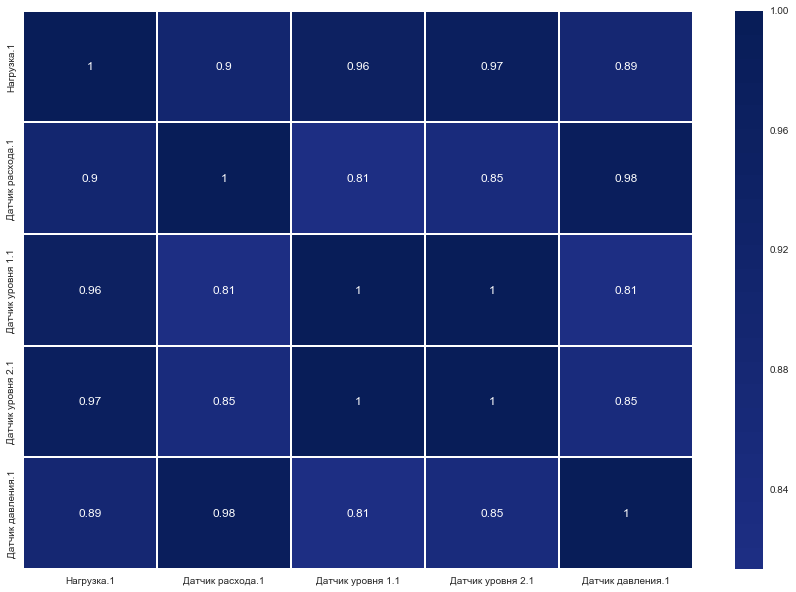

In [49]:
sns.set(rc={'figure.figsize':(15.0,10)})
sns.heatmap(df.corr(),
            annot=True,
            linewidths=1.0,
            center=0,
            cbar=True,
            cmap="YlGnBu")

Признаки в целом умеют похожие распределения

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


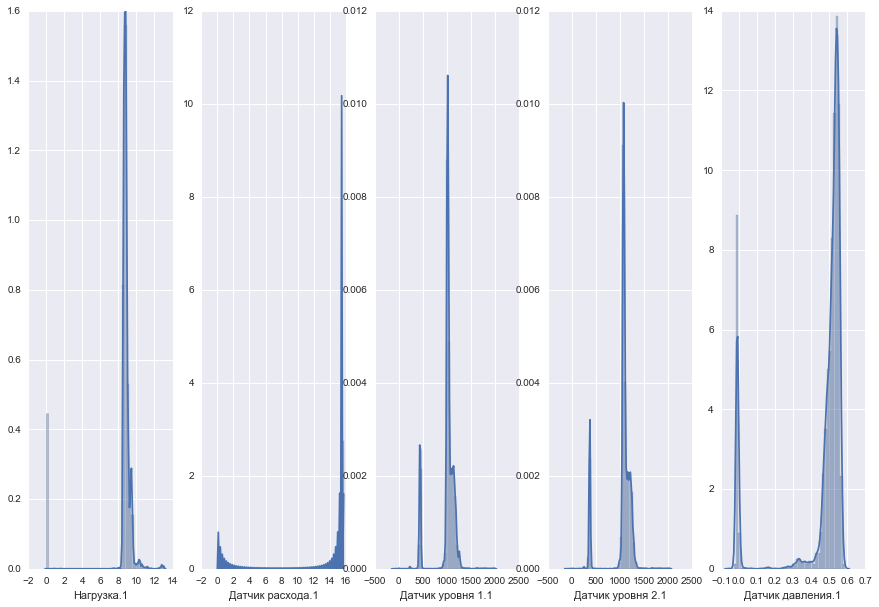

In [51]:
fig, ax =plt.subplots(1,5)
sns.distplot(df[df.columns[0]], ax=ax[0])
sns.distplot(df[df.columns[1]], ax=ax[1])
sns.distplot(df[df.columns[2]], ax=ax[2])
sns.distplot(df[df.columns[3]], ax=ax[3])
sns.distplot(df[df.columns[4]], ax=ax[4])
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


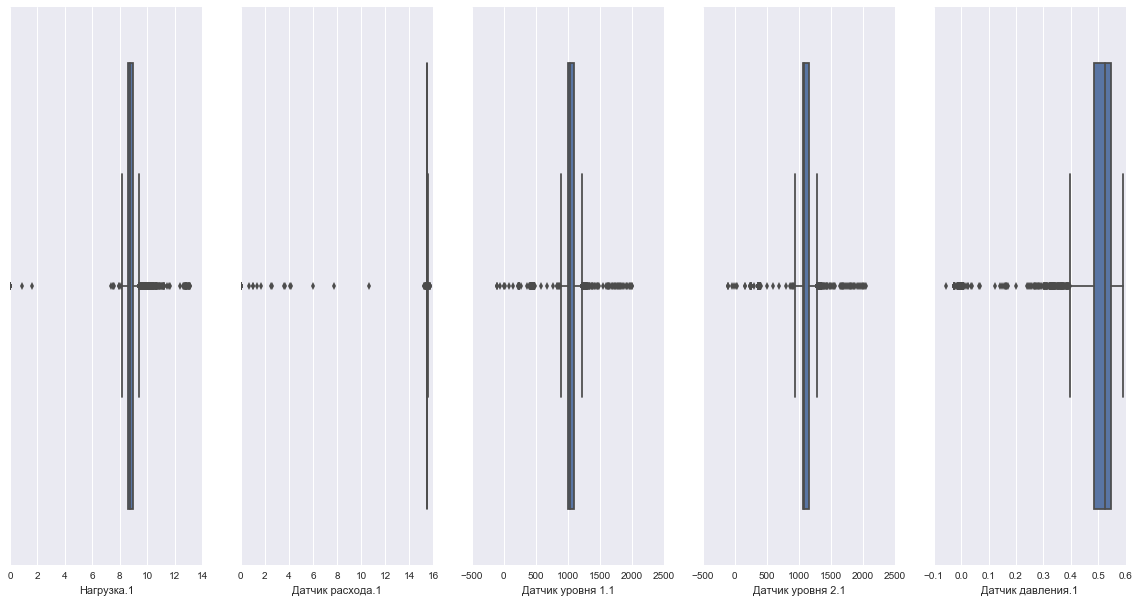

In [53]:
sns.set(rc={'figure.figsize':(20.0,10)})
fig, ax =plt.subplots(1,5)
sns.boxplot(df[df.columns[0]], ax=ax[0])
sns.boxplot(df[df.columns[1]], ax=ax[1])
sns.boxplot(df[df.columns[2]], ax=ax[2])
sns.boxplot(df[df.columns[3]], ax=ax[3])
sns.boxplot(df[df.columns[4]], ax=ax[4])
fig.show()

Проведём экспиремент без удалениея признаков, и фильтрации, как и с прошлым поднабором

Неудивительно что результат получается очень хорошим по метрике R^2

Попробуем так же посчитать rmse для сравнения предсказанных данных и реальных

In [58]:
#df1=df.drop('Датчик расхода', axis=1)
#source1=source.drop('pod3', axis=1)

valGBM=[]
testGBM=[]
valRF=[]
testRF=[]

#перемешаем данные
df.sample(frac=1)
# отделим отдельно выборку для теста
X_trainval, X_test, y_trainval, y_test = train_test_split(
   df.drop('Нагрузка.1',axis=1), df[df.columns[0]])


for number in range(10):
#перемешаем данные снова, что бы перестраховаться от случая, что в результате рандома получатся "идеальные выборки"
    X_trainval.sample(frac=1)
    #создадим тренировчную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval)
    valG,testG=GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valGBM.append(valG)
    testGBM.append(testG)
    valR,testR=RF_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valRF.append(valR)
    testRF.append(testR)
    #print ("GBM score on validation set: {:.2f}".format(valG),"Test set score : {:.2f}".format(testG) )
    #print ("RF score on validation set: {:.2f}".format(valR),"Test set score : {:.2f}".format(testR) )
    #print ("SVM score on validation set: {:.2f}".format(valS),"Test set score : {:.2f}".format(testS) )
R2_GBM_val=sum(valGBM)/len(valGBM)
R2_GBM_test=sum(testGBM)/len(testGBM)

R2_RF_val=sum(valRF)/len(valRF)
R2_RF_test=sum(testRF)/len(testRF)



print ("mean GBM score on validation set: {:.2f}".format(R2_GBM_val))
print ("mean GBM score on test set: {:.2f}".format(R2_GBM_test))
print ("mean RF score on validation set: {:.2f}".format(R2_RF_val))
print ("mean RF score on test set: {:.2f}".format(R2_RF_test))

mean GBM score on validation set: 0.99
mean GBM score on test set: 0.99
mean RF score on validation set: 0.99
mean RF score on test set: 0.99


Удалим 2 признака с наименьшей корреляцией с нагрузкой и проверим результат
Результат не изменился, следовательно можно попытаться удалить ещё один признак.

In [60]:
df1=df.drop('Датчик расхода.1', axis=1)
df1=df.drop('Датчик давления.1', axis=1)
#source1=source.drop('pod3', axis=1)

valGBM=[]
testGBM=[]
valRF=[]
testRF=[]

#перемешаем данные
df1.sample(frac=1)
# отделим отдельно выборку для теста
X_trainval, X_test, y_trainval, y_test = train_test_split(
   df1.drop('Нагрузка.1',axis=1), df1[df.columns[0]])


for number in range(10):
#перемешаем данные снова, что бы перестраховаться от случая, что в результате рандома получатся "идеальные выборки"
    X_trainval.sample(frac=1)
    #создадим тренировчную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval)
    valG,testG=GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valGBM.append(valG)
    testGBM.append(testG)
    valR,testR=RF_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valRF.append(valR)
    testRF.append(testR)
    #print ("GBM score on validation set: {:.2f}".format(valG),"Test set score : {:.2f}".format(testG) )
    #print ("RF score on validation set: {:.2f}".format(valR),"Test set score : {:.2f}".format(testR) )
    #print ("SVM score on validation set: {:.2f}".format(valS),"Test set score : {:.2f}".format(testS) )
R2_GBM_val=sum(valGBM)/len(valGBM)
R2_GBM_test=sum(testGBM)/len(testGBM)

R2_RF_val=sum(valRF)/len(valRF)
R2_RF_test=sum(testRF)/len(testRF)



print ("mean GBM score on validation set: {:.2f}".format(R2_GBM_val))
print ("mean GBM score on test set: {:.2f}".format(R2_GBM_test))
print ("mean RF score on validation set: {:.2f}".format(R2_RF_val))
print ("mean RF score on test set: {:.2f}".format(R2_RF_test))

mean GBM score on validation set: 0.99
mean GBM score on test set: 0.99
mean RF score on validation set: 0.99
mean RF score on test set: 0.99


Удаляем ещё датчик уровня 1

In [61]:
df1=df.drop('Датчик расхода.1', axis=1)
df1=df.drop('Датчик давления.1', axis=1)
df1=df.drop('Датчик уровня 1.1', axis=1)
#source1=source.drop('pod3', axis=1)

valGBM=[]
testGBM=[]
valRF=[]
testRF=[]

#перемешаем данные
df1.sample(frac=1)
# отделим отдельно выборку для теста
X_trainval, X_test, y_trainval, y_test = train_test_split(
   df1.drop('Нагрузка.1',axis=1), df1[df.columns[0]])


for number in range(10):
#перемешаем данные снова, что бы перестраховаться от случая, что в результате рандома получатся "идеальные выборки"
    X_trainval.sample(frac=1)
    #создадим тренировчную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval)
    valG,testG=GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valGBM.append(valG)
    testGBM.append(testG)
    valR,testR=RF_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valRF.append(valR)
    testRF.append(testR)
    #print ("GBM score on validation set: {:.2f}".format(valG),"Test set score : {:.2f}".format(testG) )
    #print ("RF score on validation set: {:.2f}".format(valR),"Test set score : {:.2f}".format(testR) )
    #print ("SVM score on validation set: {:.2f}".format(valS),"Test set score : {:.2f}".format(testS) )
R2_GBM_val=sum(valGBM)/len(valGBM)
R2_GBM_test=sum(testGBM)/len(testGBM)

R2_RF_val=sum(valRF)/len(valRF)
R2_RF_test=sum(testRF)/len(testRF)



print ("mean GBM score on validation set: {:.2f}".format(R2_GBM_val))
print ("mean GBM score on test set: {:.2f}".format(R2_GBM_test))
print ("mean RF score on validation set: {:.2f}".format(R2_RF_val))
print ("mean RF score on test set: {:.2f}".format(R2_RF_test))

mean GBM score on validation set: 0.99
mean GBM score on test set: 0.99
mean RF score on validation set: 0.99
mean RF score on test set: 0.99


Модель не теряет свойств, при удалении 3 признаков из 4

Фильтрация данных не требуется, регрессоры достаточно хорошо обобщают выборку, что подтверждается валидационным и тестирующими выборками.
Теперь посчитаем отдельно RMSE и сравним реальную нагрузку и предсказанную

In [73]:
def GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test):
    model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=10)
    model.fit(X_train, y_train)
    #проверка на валидационном сете
    val_pred = model.predict(X_valid)
    r2_val= mean_squared_error(y_valid, val_pred)
    #проверка на тестовом сете
    test_pred = model.predict(X_test)
    r2_test= mean_squared_error(y_test, test_pred)
    return r2_val, r2_test
    #return (print("GBM score on validation set: {:.2f}".format(r2_val),"Test set score : {:.2f}".format(r2_test) ))

In [75]:
valGBM=[]
testGBM=[]

df1.sample(frac=1)
X_trainval, X_test, y_trainval, y_test = train_test_split(
   df1.drop('Нагрузка.1',axis=1), df1[df.columns[0]])


for number in range(1):
    X_trainval.sample(frac=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval)
    valG,testG=GBM_results(X_train, y_train,X_valid,y_valid, X_test, y_test)
    valGBM.append(valG)
    testGBM.append(testG)

R2_GBM_val=sum(valGBM)/len(valGBM)
R2_GBM_test=sum(testGBM)/len(testGBM)



print ("mean GBM RMSE score on validation set: {:.2f}".format(R2_GBM_val))
print ("mean GBM RMSE score on test set: {:.2f}".format(R2_GBM_test))

mean GBM RMSE score on validation set: 0.02
mean GBM RMSE score on test set: 0.06


Запускал несколько раз, в среднем получается ошибка меньше 0.1 , на тестовом и валидационном сете

Выводы:
Второй поднабор данных очень сильно связан между собой, почти все признки имеют большую корреляцию с зависимой переменной
и между собой

Для предсказания можно использовать 1 признак из 4, при этом качество модели не ухудшается

Фильтрация данных при таких хороших результатах не требуется

Предсказанные значения отличаются от реальных в среднем на чуть меньше чем 0.1
